In [1]:
import pdb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gridrender as gui
import math
import os
import time
import pdb
import numbers

from gridworld import GridWorld, two_rooms_grid, two_rooms_computeOptions
from RL_methods import PolicyLearning, ValueLearning
from HRL_methods import Option, MAXQ
from anytree import Node, PreOrderIter
from anytree.search import findall_by_attr
from anytree.render import RenderTree

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import tqdm

# Two Room Setting for Option Discovery

In [4]:
W = 10
H = 10
DH = 2
DP = 5
twoRooms_grid = two_rooms_grid(room_width=W, room_height=H, doorway_pos=DP, doorway_height=DH, goal_height=0)

In [5]:
for line in twoRooms_grid:
    print("".join(map(lambda x: '.' if x == '' else str(x),line)))

..........x.........1
..........x..........
..........x..........
..........x..........
.....................
.....................
..........x..........
..........x..........
..........x..........
..........x..........


## Reseting density
We have modified the gridworld code so that to specify a specific resetting density (here we want x0 to be in the left hand room)

In [6]:
# reset density : uniform in left hand side
reset_density = np.zeros((len(twoRooms_grid),len(twoRooms_grid[0])))
for i in range(reset_density.shape[0]):
    for j in range(reset_density.shape[1]):
        if twoRooms_grid[i][j] != 'x' and 'x' in twoRooms_grid[i][j:]:
            reset_density[i][j] = 1
reset_density /= reset_density.sum()

In [9]:
twoRooms = GridWorld(static_filter=static_filter, gamma=0.9, grid=twoRooms_grid, reset_density=reset_density)

## Testing the reseting density
The 'o' marks the starting point, it should always be in the left hand side.

In [10]:
x0 = twoRooms.reset()
i,j = twoRooms.state2coord[x0]
twoRooms_grid = two_rooms_grid(room_width=W, room_height=H, doorway_pos=DP, doorway_height=DH, goal_height=0)
twoRooms_grid[i][j] = 'o'
for line in twoRooms_grid:
    print("".join(map(lambda x: '.' if x == '' else str(x),line)))

........o.x.........1
..........x..........
..........x..........
..........x..........
.....................
.....................
..........x..........
..........x..........
..........x..........
..........x..........


In [16]:
%%time
trajectories = []
MAXQi = MAXQ(twoRooms, expl0=0.0, n_iter=5000, runOnCreate=False)
for it in tqdm.tqdm(range(100)):
    initState = twoRooms.reset()
    MAXQi.actions.option.log = 'active'
    MAXQi.it = it
    MAXQi.time = 1
    MAXQi.run(MAXQi.actions, initState, False, history=True)
    trajectories.append([[s,x,y] for s,x,y in MAXQi.lastTraj if static_filter(s)])

  0%|          | 0/100 [00:00<?, ?it/s]

Root
├── right
├── down
├── left
└── up


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]

CPU times: user 39.7 s, sys: 301 ms, total: 40 s
Wall time: 39.8 s


## 40 episodes Q-Learning

In [28]:
%%time
P = PolicyLearning(ind=0, GridWorld=twoRooms, max_iter=40)
record_trajectory = []
P.run(record_trajectory = record_trajectory)

CPU times: user 7.35 s, sys: 20 ms, total: 7.37 s
Wall time: 7.37 s


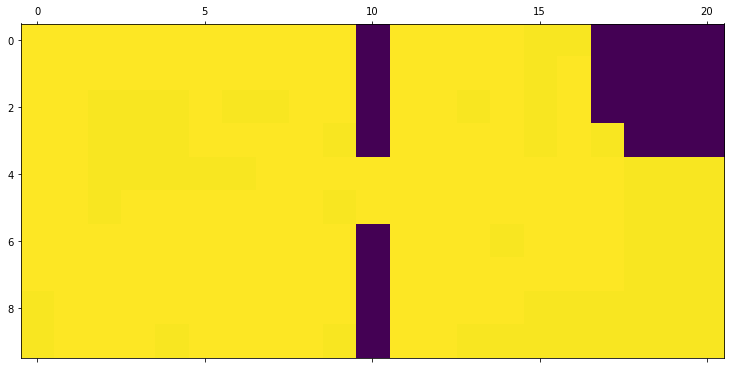

In [17]:
DD_map = get_DD_map(trajectories, static_filter)
plt.matshow(DD_map)
plt.show()

In [25]:
DD_map

array([[100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,   0.,
        100., 100.,  99.,  99.,  99.,  99.,   0.,   0.,   0.,   0.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,   0.,
        100., 100., 100., 100.,  99., 100.,   0.,   0.,   0.,   0.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,   0.,
        100., 100., 100., 100., 100., 100.,   0.,   0.,   0.,   0.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,   0.,
        100., 100., 100., 100., 100., 100., 100.,   0.,   0.,   0.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100.],
       [100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,   0.,
         99.,  99., 100., 100., 100., 100., 100., 100., 100., 100.],

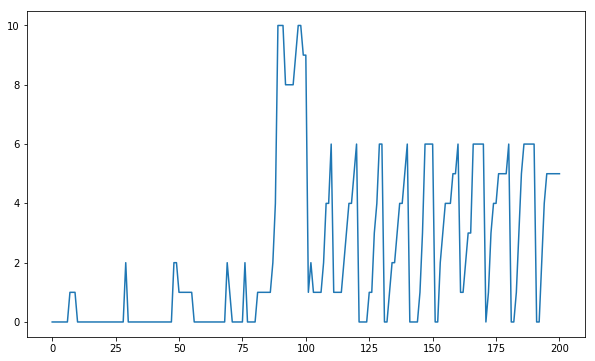

In [50]:
y = []
for s in range(twoRooms.n_states):
    i,j = twoRooms.state2coord[s]
    y.append(DD_map[i,j])
plt.plot(y)
plt.show()

## Compute the Diverse Density of state s

In [14]:
def gaussian_dist(center,B):
    center_np = np.array(twoRooms.state2coord[center])
    B_np = np.array(twoRooms.state2coord[B])
    return np.exp(-np.linalg.norm(B_np-center_np))

def DD_old(s, record_trajectory, static_filter = lambda x: True):
    
    log_sum = 0
    for traj in record_trajectory:
        product = 1
        for x,a,r in traj:
            if static_filter(x):
                product *= (1-gaussian_dist(center=s,B=x))
        log_sum += np.log(1-product)
    
    return log_sum

def get_DD_map(record_trajectory, static_filter = lambda x: True):
    
    DD_map = np.zeros((len(twoRooms_grid),len(twoRooms_grid[0])))
    count = {}
    for s in range(twoRooms.n_states):
        count[s] = 0
    for traj in record_trajectory:
        seen = {}
        for x,_,_ in traj:
            if not x in seen and static_filter(x):
                i,j = twoRooms.state2coord[x]
                DD_map[i,j] += 1
                seen[x] = True
    
    return DD_map

In [8]:
def static_filter(s,dist_to_goal=4):
    objective = np.array([0,len(twoRooms_grid[0])-1])
    coord_s = np.array(twoRooms.state2coord[s])
    return np.linalg.norm(objective-coord_s) >= dist_to_goal
twoRooms_grid = two_rooms_grid(room_width=10, room_height=10, doorway_pos=5, doorway_height=2, goal_height=0)
for s in range(twoRooms.n_states):
    if not static_filter(s,4):
        i,j = twoRooms.state2coord[s]
        twoRooms_grid[i][j] = "~"
for line in twoRooms_grid:
    print("".join(map(lambda x: '.' if x == '' else str(x),line)))

NameError: name 'twoRooms' is not defined

In [13]:
DD_map = get_DD_map(record_trajectory, static_filter)